<a href="https://colab.research.google.com/github/ph7klw76/SMEB2201_Lecture_on_QM_in_Materials_Science/blob/main/QM_and_Global_Warming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: This is a machine-learning trained Quantum Molecular Mechanics Model. It has been tested up to 200 atoms for geometry optimization and frequency calculation using ANI2x model.( see https://pubs.acs.org/doi/10.1021/acs.jctc.0c00121)* 

## **This module links quantum mechanics with issue of Global Warming.**


In [ ]:
!pip install ase
!pip install torchani
!pip install torch

You need to install the packages in order to run this program
for further information, please check 

https://wiki.fysik.dtu.dk/ase/ Atomic Simulation Environment &
https://aiqm.github.io/torchani/ Torchani


In [ ]:
from ase import Atoms
from ase.optimize import BFGS
import torchani
import torch


In [ ]:
d = 1.08  # N2 bondlength
N2 = Atoms(numbers=[7, 7], positions=[(0, 0, 0), (0, 0, d)]) # numbers are atomic numbers, and positions are the x,y,z coordinates 
CO2=Atoms(numbers=[6,8,8], positions=[(0, 0, 0), (1.190, 0, 0),(-1.190, 0, 0)])
H20 = Atoms(numbers=[8,1,1], positions=[(0, 0, 0), (0.757, 0.586, 0.0),(-0.757, 0.586, 0.0)]) # numbers are atomic numbers, and positions are the x,y,z coordinates 
nonoptbenzene = Atoms(numbers=[6,6,6,6,6,6,1,1,1,1,1,1],positions=[(0.16094800,-1.89749200,0.00000000),(1.44076900,-0.64590500,-0.00000800),(1.37979500,0.75152600,0.00000600),(-0.16101700,1.39749300,-0.00000100),(-1.24074000,0.64596400,-0.00000500),(-1.17975600,-0.75158500,0.00000700),(0.10846900,-2.48458400,-0.00000700),(2.20590000,-1.14845500,0.00000100),(2.09748300,1.33623100,0.00001100),(-0.10835800,2.48459400,0.00000900),(-2.20595700,1.14834900,-0.00002100),(-2.09753600,-1.33614300,0.00001700)])
benzene = Atoms(numbers=[6,6,6,6,6,6,1,1,1,1,1,1],positions=[(0.06094800,-1.39749200,0.00000000),(1.24076900,-0.64590500,-0.00000800),(1.17979500,0.75152600,0.00000600),(-0.06101700,1.39749300,-0.00000100),(-1.24074000,0.64596400,-0.00000500),(-1.17975600,-0.75158500,0.00000700),(0.10846900,-2.48458400,-0.00000700),(2.20590000,-1.14845500,0.00000100),(2.09748300,1.33623100,0.00001100),(-0.10835800,2.48459400,0.00000900),(-2.20595700,1.14834900,-0.00002100),(-2.09753600,-1.33614300,0.00001700)])

These are the molecules defined in this demostration

In [ ]:
def minimization(molecule):
  calculator = torchani.models.ANI2x().ase()
  molecule.set_calculator(calculator)
  print("Begin minimizing...")
  opt = BFGS(molecule)
  opt.run(fmax=0.00005)
  print()
  print(molecule.get_positions())
  return molecule

The function minimization takes in the structure of molecules and optimize the molecular structure using BFGS with threshold of minimization of forcefield of 0.00005. 

In [ ]:
optbenzene=minimization(benzene) # optimizing the benzene structure

Begin minimizing...
      Step     Time          Energy         fmax
BFGS:    0 07:34:35    -6317.915671        0.3048
BFGS:    1 07:34:35    -6317.919177        0.1651
BFGS:    2 07:34:35    -6317.920843        0.0999
BFGS:    3 07:34:35    -6317.922111        0.0072
BFGS:    4 07:34:36    -6317.922113        0.0007
BFGS:    5 07:34:36    -6317.922112        0.0004
BFGS:    6 07:34:36    -6317.922114        0.0002
BFGS:    7 07:34:36    -6317.922112        0.0001
BFGS:    8 07:34:36    -6317.922113        0.0002
BFGS:    9 07:34:36    -6317.922112        0.0001
BFGS:   10 07:34:36    -6317.922111        0.0000

[[ 6.07023086e-02 -1.39111591e+00  2.29299746e-08]
 [ 1.23509212e+00 -6.42988679e-01  5.42538283e-07]
 [ 1.17439003e+00  7.48126680e-01  4.46899357e-06]
 [-6.07024569e-02  1.39111464e+00  1.04431437e-06]
 [-1.23509204e+00  6.42987337e-01 -3.12663825e-06]
 [-1.17439006e+00 -7.48128122e-01  9.01559291e-07]
 [ 1.08112085e-01 -2.47763141e+00 -2.30793626e-06]
 [ 2.19974801e+00 -1.14

Output of minimized geometry structure to optbenzene so that it can be passed to other functions

As the energy decreases the fmax decreases. Fmax is the maximum force acting on the molecules. At equilibrium, the force must be minimum and hence the energy of the molecules must be minimum.Rememeber F= -dU/dr, where U is the potential energy as shown in Figure below:

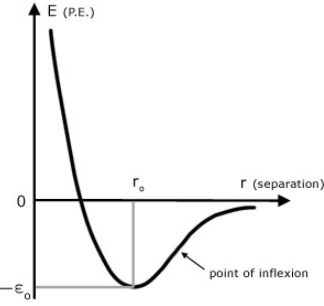


BFGS is an algorithm to find the solution of minimum. When molecules are very complex, it is not so easy to find the global minimum as the energy landscape is very complex as shown in Figure below. 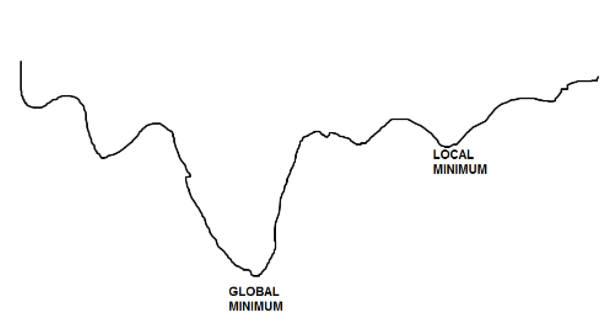

In [ ]:
def vibration(molecule):
  device = torch.device('cpu')
  model = torchani.models.ANI2x(periodic_table_index=True).to(device).double()
  species = torch.tensor(molecule.get_atomic_numbers(), device=device, dtype=torch.long).unsqueeze(0)
  coordinates = torch.from_numpy(molecule.get_positions()).unsqueeze(0).requires_grad_(True)

  masses = torchani.utils.get_atomic_masses(species)
  energies = model((species, coordinates)).energies
  hessian = torchani.utils.hessian(coordinates, energies=energies)
  print(hessian.shape)
  freq, modes, fconstants, rmasses = torchani.utils.vibrational_analysis(masses, hessian, mode_type='MDU')
  torch.set_printoptions(precision=3, sci_mode=False)
  print('Frequencies (cm^-1):', freq[6:])
  return molecule


In [ ]:
vibration(optbenzene)  # calling vibration function

torch.Size([1, 36, 36])
Frequencies (cm^-1): tensor([ 438.951,  438.951,  623.478,  623.478,  671.679,  770.784,  878.019,
         878.020,  992.976,  992.977, 1018.848, 1027.771, 1046.487, 1091.460,
        1091.460, 1197.356, 1239.524, 1239.525, 1331.667, 1411.824, 1560.413,
        1560.413, 1709.432, 1709.434, 3222.610, 3237.861, 3237.863, 3246.819,
        3246.821, 3266.453], dtype=torch.float64)


Atoms(symbols='C6H6', pbc=False, calculator=Calculator(...))

Once you have the optimized molecular structure, the vibrational frequency can be calculated as the bond between atoms can act like a 'spring' with attached mass. This function calculates the vibrational frequency of the optimized geometry of a benzene ring. This frequency corresponds to the IR and far IR absorption wavelengths. 
Note it doesnt contain any negative frequency


Using non-optimzed geometry results in negative frequency, here it is indicated as nan

In [ ]:
vibration(nonoptbenzene)

torch.Size([1, 36, 36])
Frequencies (cm^-1): tensor([      nan,       nan,       nan,       nan,     0.000,   131.669,
          245.250,   317.622,   385.202,   496.225,   539.840,   575.626,
          706.305,   712.378,   816.386,   883.675,   908.209,   938.128,
         1209.667,  1275.269,  1284.498,  1482.638,  1644.551,  1730.833,
         2086.720,  3224.845,  3229.987,  3284.337,  5039.074,  5218.789],
       dtype=torch.float64)


Atoms(symbols='C6H6', pbc=False)

### **Greenhouse Gas- How Quantum Mechanics can be used to verify CO2 is a greenhouse gas?**

In [ ]:
optCO2=minimization(CO2)


Begin minimizing...
      Step     Time          Energy         fmax
BFGS:    0 07:35:16    -5130.226740        2.7142
BFGS:    1 07:35:16    -5130.273799        1.6913
BFGS:    2 07:35:16    -5130.296625        0.1288
BFGS:    3 07:35:16    -5130.296767        0.0055
BFGS:    4 07:35:16    -5130.296767        0.0000

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.16501122e+00 -2.32662364e-21  0.00000000e+00]
 [-1.16501122e+00  0.00000000e+00  0.00000000e+00]]


In [ ]:
vibration(optCO2)

torch.Size([1, 9, 9])
Frequencies (cm^-1): tensor([ 645.523, 1413.885, 2489.089], dtype=torch.float64)


Atoms(symbols='CO2', pbc=False, calculator=Calculator(...))

The output is in the unit of cm^-1

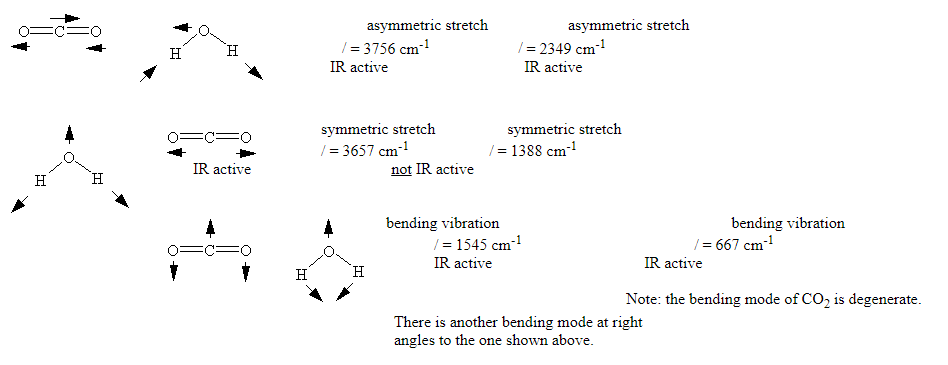

Only the IR active is calculated. At what wavelength in nm the CO2 overlap with the blackbody radiation of the sun? http://halas.rice.edu/conversions  for conversion between cm^-1 to nm

Now try H2O, what IR does it absorb? Is it a greenhouse gas, if yes , why it is, if no why not?

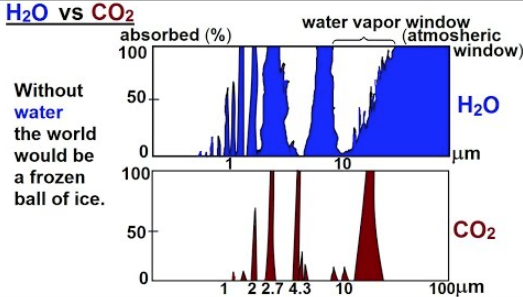

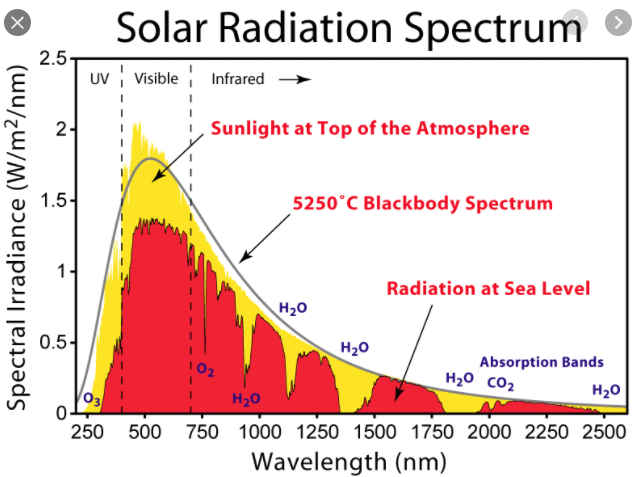